In [1]:
from math import log2, sqrt, exp

import numpy as np
import random
import pandas as pd

random.seed(42)

In [2]:
from matplotlib import pyplot as plt

plt.style.use({'figure.facecolor':'white'})

def plot(title, classifier, xs, ys):
    plt.title(label=title)
    details = 40
    x_min, x_max = np.min(xs[:, 0]), np.max(xs[:, 0])
    y_min, y_max = np.min(xs[:, 1]), np.max(xs[:, 1])
    x_step = (x_max - x_min) / details
    y_step = (y_max - y_min) / details
    generated_x_axis = np.arange(x_min, x_max + x_step, x_step)
    generated_y_axis = np.arange(y_min, y_max + y_step, y_step)
    for i in range(len(generated_x_axis)):
        for j in range(len(generated_y_axis)):
            point = [generated_x_axis[i], generated_y_axis[j]]
            y_pred = classifier.predict(point)
            c = "red" if y_pred == 1 else "blue"
            plt.scatter(*point, color=c, s=50, marker="s")

    for i in range(len(xs)):
        x, y = xs[i], ys[i]
        c = "orange" if y == 1 else "cyan"
        plt.scatter(*x, color=c, s=50, edgecolors='white')

    plt.show()

In [3]:
class Leaf:
    def __init__(self, y):
        self.y = y
        self.w = 1


class Node:
    def __init__(self, j, bj):
        self.j = j
        self.bj = bj
        self.left_child = None
        self.right_child = None
        self.w = 1


class DecisionTreeClassifier:
    def __init__(self, k, random_features):
        self.k = k
        self.root = None
        self.random_features = random_features

    def build_tree(self, ws, xs, ys, max_h, h):
        m = len(xs[0])

        if self.random_features:
            features = random.sample(range(m), int(sqrt(m)))
        else:
            features = list(range(m))

        cnt_ys = 0
        freq = [0] * self.k
        log_sum = 0
        for i in range(len(ys)):
            freq[ys[i]] += ws[i]

        weight = 0
        for i in range(len(xs)):
            weight += ws[i]

        major_freq = -1
        major = -1
        for y in range(self.k):
            if freq[y] > 0:
                log_sum += freq[y] * log2(freq[y])
                cnt_ys += 1
            if freq[y] > major_freq:
                major_freq = freq[y]
                major = y

        if cnt_ys <= 1 or (max_h is not None and h == max_h):
            return Leaf(major)

        max_gain = (log_sum - log2(weight) * weight) / weight
        best_j = 0
        best_bj = max(list(map(lambda feature: feature[features[0]], xs))) + 1
        for j in features:
            pairs = [0] * len(xs)
            for i in range(len(xs)):
                pairs[i] = (xs[i][j], i)
            pairs.sort(key=lambda pr: pr[0])

            freq_prefix = [0] * self.k
            prefix_log_sum = 0
            prefix_weight = 0
            suffix_log_sum = log_sum

            for i in range(len(pairs)):
                border, ind = pairs[i]
                y = ys[ind]

                if i == 0 or border != pairs[i - 1][0]:
                    phi_prefix = 0
                    if prefix_weight > 0:
                        phi_prefix = (prefix_log_sum - log2(prefix_weight) * prefix_weight) / prefix_weight

                    phi_suffix = 0
                    if weight - prefix_weight > 0:
                        phi_suffix = (suffix_log_sum - log2(weight - prefix_weight) * (weight - prefix_weight)) / (weight - prefix_weight)

                    gain = i / len(xs) * phi_prefix + (len(xs) - i) / len(xs) * phi_suffix
                    if gain > max_gain:
                        max_gain = gain
                        best_j = j
                        best_bj = border

                if freq_prefix[y] > 0:
                    prefix_log_sum -= freq_prefix[y] * log2(freq_prefix[y])
                suffix_log_sum -= (freq[y] - freq_prefix[y]) * log2(freq[y] - freq_prefix[y])
                freq_prefix[y] += ws[ind]
                prefix_log_sum += freq_prefix[y] * log2(freq_prefix[y])
                prefix_weight += ws[ind]
                if freq[y] - freq_prefix[y] > 0:
                    suffix_log_sum += (freq[y] - freq_prefix[y]) * log2(freq[y] - freq_prefix[y])

        left_xs = []
        left_ys = []
        right_xs = []
        right_ys = []
        for i in range(len(xs)):
            if xs[i][best_j] < best_bj:
                left_xs.append(xs[i])
                left_ys.append(ys[i])
            else:
                right_xs.append(xs[i])
                right_ys.append(ys[i])

        if len(left_xs) == 0 or len(right_xs) == 0:
            return Leaf(major)

        node = Node(best_j, best_bj)

        left_child = self.build_tree(ws, left_xs, left_ys, max_h, h + 1)
        right_child = self.build_tree(ws, right_xs, right_ys, max_h, h + 1)

        node.left_child = left_child
        node.right_child = right_child
        node.w = left_child.w + right_child.w + 1

        return node

    def fit(self, ws, xs, ys, h):
        ys_labeled = list(map(lambda label: 0 if label == -1 else 1, ys))
        self.root = self.build_tree(ws, xs, ys_labeled, h, 0)


    def predict_recursive(self, node, x):
        if isinstance(node, Leaf):
            return node.y

        if x[node.j] < node.bj:
            return self.predict_recursive(node.left_child, x)
        return self.predict_recursive(node.right_child, x)

    def predict(self, x):
        y = self.predict_recursive(self.root, x)
        return -1 if y == 0 else 1


In [4]:
class RandomForestClassifier:
    def __init__(self, k, trees_number):
        self.k = k
        self.trees_number = trees_number
        self.trees = []

    def fit(self, x_train, y_train):
        self.trees = []
        for _ in range(self.trees_number):
            xs = [0] * len(x_train)
            ys = [0] * len(x_train)

            for i in range(len(x_train)):
                ind = random.randint(0, len(x_train) - 1)
                xs[i] = x_train[ind]
                ys[i] = y_train[ind]

            self.trees.append(DecisionTreeClassifier(self.k, True))
            ws = [1] * len(x_train)
            self.trees[-1].fit(ws, xs, ys, None)

    def predict(self, x):
        y_pred = [0] * self.trees_number
        for i in range(self.trees_number):
            classifier = self.trees[i]
            y_pred[i] = classifier.predict(x)
        neg = y_pred.count(-1)
        pos = y_pred.count(1)
        return 1 if pos >= neg else -1

In [5]:
import math


class AdaBoostClassifier:
    def __init__(self, k, t, steps):
        self.k = k
        self.t = t
        self.classifiers = []
        self.alphas = [0] * t
        self.steps = steps
        self.accuracies = []

    def fit(self, x_train, y_train, to_plot = False):
        self.classifiers = []
        self.accuracies = []
        w = [0] * len(x_train)
        for i in range(len(x_train)):
            w[i] = 1 / len(x_train)
        for step in range(self.t):
            self.classifiers.append(DecisionTreeClassifier(self.k, False))
            self.classifiers[step].fit(w, x_train, y_train, 2)
            y_preds = list(map(self.classifiers[step].predict, x_train))
            errors = 0
            for i in range(len(y_train)):
                if y_preds[i] != y_train[i]:
                    errors += w[i]

            if errors == 0:
                alpha = 10
            else:
                alpha = 0.5 * math.log((1 - errors) / errors)

            sm = 0
            for i in range(len(x_train)):
                w[i] *= exp(-1 * alpha * y_train[i] * y_preds[i])
                sm += w[i]
            for i in range(len(x_train)):
                w[i] /= sm

            self.alphas[step] = alpha

            self.accuracies.append((len(x_train) - errors) / len(x_train))

            if to_plot and step in self.steps:
                plot(f"AdaBoost after {step} step", self, x_train, y_train)

    def predict(self, x):
        res = 0
        for i in range(len(self.classifiers)):
            pred = self.classifiers[i].predict(x)
            res += self.alphas[i] * pred

        return -1 if res < 0 else 1


In [6]:
chips_dataset = pd.read_csv("data/chips.csv")
geyser_dataset = pd.read_csv("data/geyser.csv")

print(chips_dataset)
print(geyser_dataset)

            x         y class
0    0.051267  0.699560     P
1   -0.092742  0.684940     P
2   -0.213710  0.692250     P
3   -0.375000  0.502190     P
4   -0.513250  0.465640     P
..        ...       ...   ...
113 -0.720620  0.538740     N
114 -0.593890  0.494880     N
115 -0.484450  0.999270     N
116 -0.006336  0.999270     N
117  0.632650 -0.030612     N

[118 rows x 3 columns]
      x    y class
0     1  4.4     N
1     1  3.9     N
2     1  4.0     P
3     1  4.0     N
4     1  3.5     N
..   ..  ...   ...
217  23  2.1     P
218  23  4.2     N
219  23  2.1     P
220  23  5.2     N
221  23  2.0     P

[222 rows x 3 columns]


In [7]:
def normalize(y):
    return np.fromiter(map(lambda s: 1 if s == "P" else -1, y), dtype=float)

x_chips = chips_dataset.drop(["class"], axis=1).to_numpy(dtype=float)
y_chips = normalize(chips_dataset["class"].to_numpy())

x_geyser = geyser_dataset.drop(["class"], axis=1).to_numpy(dtype=float)
y_geyser = normalize(geyser_dataset["class"].to_numpy())

In [8]:
ada_boost = AdaBoostClassifier(2, 2, [])
ada_boost.fit(x_chips, y_chips, False)
ada_boost.predict(x_chips[0])

1

In [9]:
from sklearn.model_selection import KFold

def cross_validate(classifier, xs, ys):
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(xs):
        x_train, y_train = xs[train_index], ys[train_index]
        x_test, y_test = xs[test_index], ys[test_index]
        classifier.fit(x_train, y_train)
        correct = 0
        for i in range(len(x_test)):
            y_pred = classifier.predict(x_test[i])
            if y_pred == y_test[i]:
                correct += 1
        return correct / len(x_test)

Geyser:
0.8888888888888888


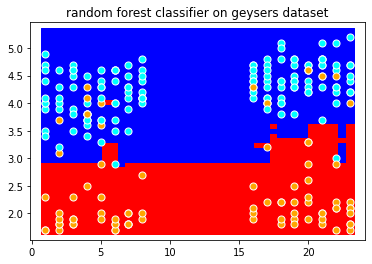

Chips:
0.4583333333333333


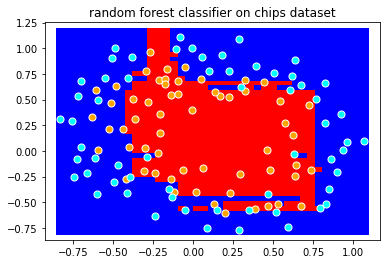

In [10]:
random_forest_classifier = RandomForestClassifier(2, 60)
accuracy = cross_validate(random_forest_classifier, x_geyser, y_geyser)
print("Geyser:")
print(accuracy)

plot("random forest classifier on geysers dataset", random_forest_classifier, x_geyser, y_geyser)

accuracy = cross_validate(random_forest_classifier, x_chips, y_chips)
print("Chips:")
print(accuracy)

plot("random forest classifier on chips dataset", random_forest_classifier, x_chips, y_chips)

In [11]:
STEPS = [1, 2, 3, 5, 8, 13, 21, 34, 55]

ada_boost = AdaBoostClassifier(2, 100, STEPS)

accuracy = cross_validate(ada_boost, x_geyser, y_geyser)
print("Geyser:")
print(accuracy)

accuracy = cross_validate(ada_boost, x_chips, y_chips)
print("Chips:")
print(accuracy)

Geyser:
0.8888888888888888
Chips:
0.75


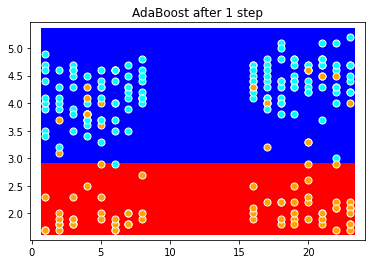

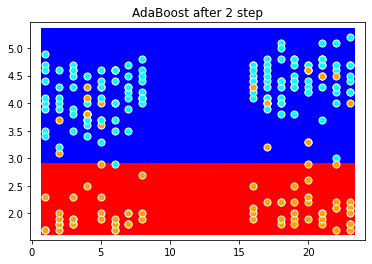

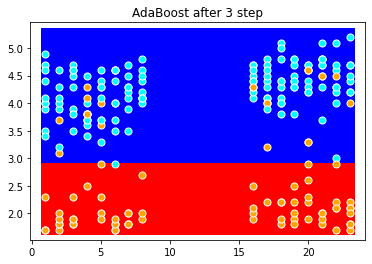

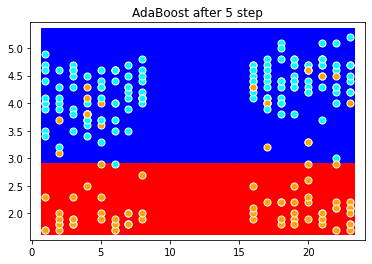

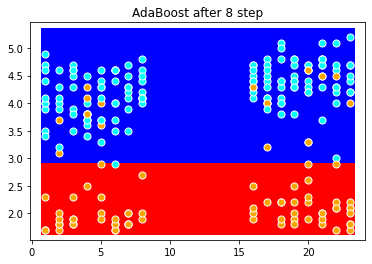

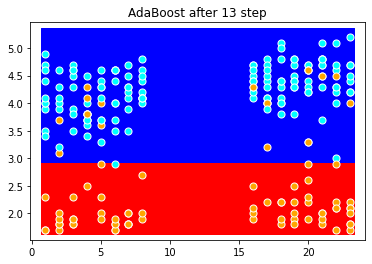

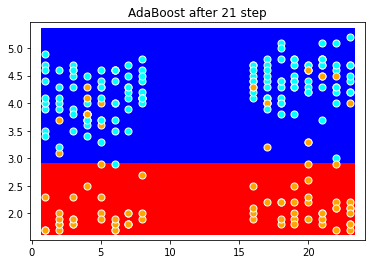

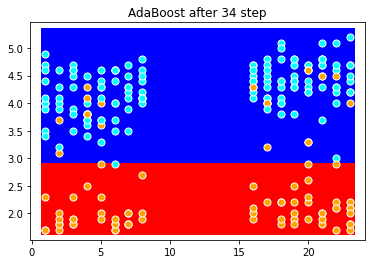

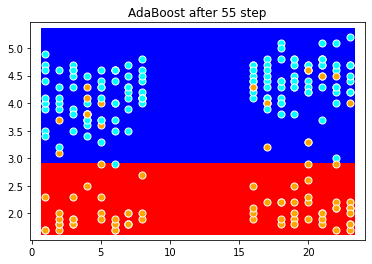

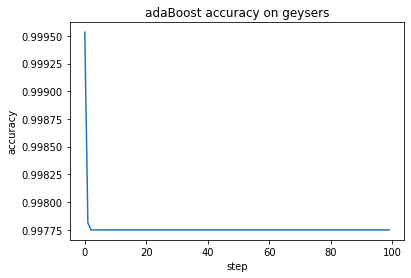

In [12]:
ada_boost = AdaBoostClassifier(2, 100, STEPS)
ada_boost.fit(x_geyser, y_geyser, to_plot=True)

plt.plot(ada_boost.accuracies)
plt.xlabel("step")
plt.ylabel("accuracy")
plt.title("adaBoost accuracy on geysers")
plt.show()

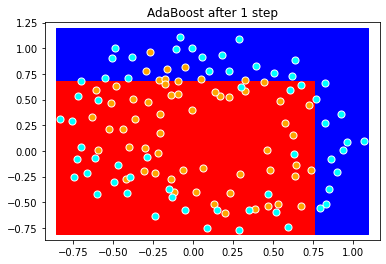

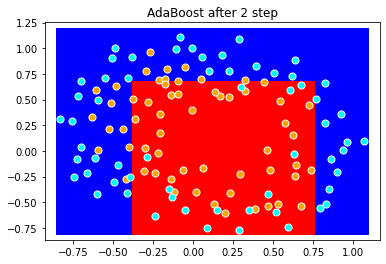

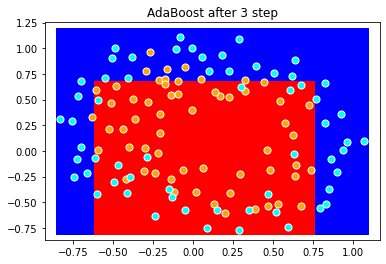

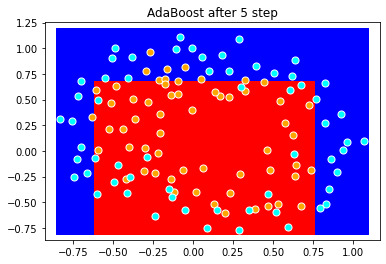

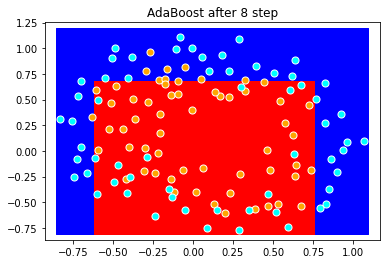

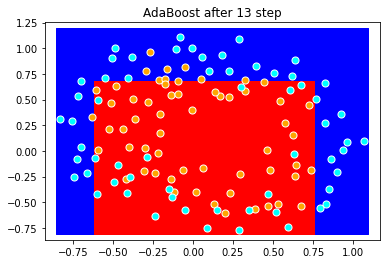

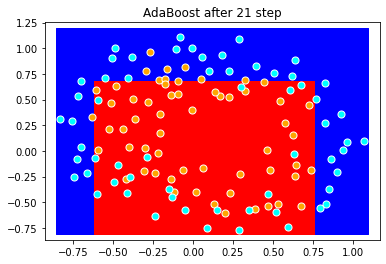

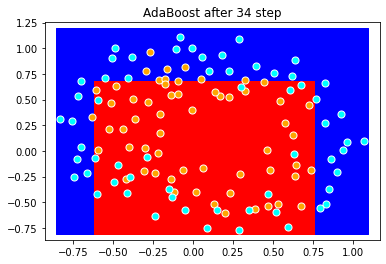

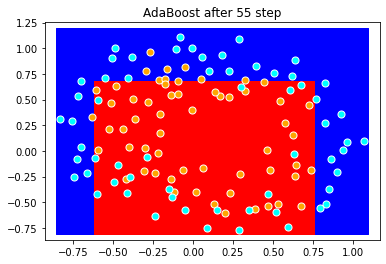

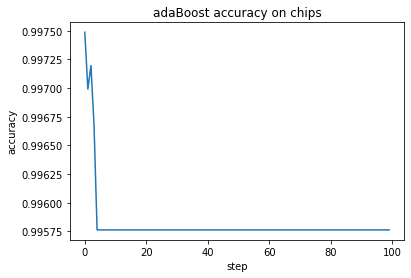

In [15]:
ada_boost = AdaBoostClassifier(2, 100, STEPS)
ada_boost.fit(x_chips, y_chips, to_plot=True)

plt.plot(ada_boost.accuracies)
plt.xlabel("step")
plt.ylabel("accuracy")
plt.title("adaBoost accuracy on chips")
plt.show()
